## Topics in Smart Health Informatics
### Assignment 3

Name: Komal Barge (1095709)

Given dataset of 1500 CT scans of various parts of the body such as abdomen, chest and head has to be trained with machine leanring models to classify the images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import pickle
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

Using TensorFlow backend.


In [3]:
#set the current directory to given path
os.chdir("./Documents/DS")

In [4]:
#get all the images from set path
filenames = os.listdir()
categories = []
X = []

#fetch the target labels for all the images
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'Abdomen':
        categories.append(0)
    elif category == 'Chest':
        categories.append(1)
    else:
        categories.append(2)
    img = Image.open(filename)        #open an image
    img = img.resize((32,32))         #resize an image to 32x32 size
    imgArray = np.asarray(img)
    X.append(imgArray)

In [5]:
#reshape the image to send it in convolutional neural networks.
X = np.array(X).astype(np.float32)
X = np.reshape(X, (-1,32,32,1))
y = np.array(categories).astype(np.float32)

In [6]:
#split the data in 70:30 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
#convert the target labels to categorical matrix
from keras.utils import to_categorical
yTrain = to_categorical(y_train, 3)
yTest = to_categorical(y_test, 3)

In [8]:
#############Preprocess an image with imageDataGenerator#################

#Image Augmentations techniques are methods of artificially increasing the variations of images 
#in our data-set by using horizontal flips, rotations, changing the zoom and shear range etc.

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, yTrain, batch_size=32)        #to generate batches of augmented train images
test_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test)                              #to generate batches of augmented test images

In [9]:
#build a CNN model to extract features from the images.
activationFunction = 'relu'
def getCNNModel():
    model = Sequential()
    model.add(Conv2D(25, kernel_size=(3,3) ,input_shape=X[0].shape,    
                  activation=activationFunction))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(16, kernel_size=(2,2), activation=activationFunction))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(8, kernel_size=(2,2), activation=activationFunction))
    model.add(MaxPooling2D(pool_size=1))
    
    model.add(Flatten())
    model.add(Dense(50, activation=activationFunction, name = "extractedFeature"))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

modelCNN = getCNNModel()

In [10]:
#we will fit the model augmented images to get the trained layers with proper weight adjustments.
history = modelCNN.fit_generator(train_generator,epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 66ms/step - loss: 0.4665 - accuracy: 0.8000
Epoch 2/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0530 - accuracy: 0.9838
Epoch 3/5
33/33 [==============================] - 2s 63ms/step - loss: 0.0163 - accuracy: 0.9990
Epoch 4/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0201 - accuracy: 0.9962 0s - loss: 0.0225 - accura
Epoch 5/5
33/33 [==============================] - 2s 60ms/step - loss: 0.0180 - accuracy: 0.9924


In [11]:
#Extract features from second last dense layer in above CNN architecture
extractedModel = keras.models.Model(inputs=modelCNN.input, outputs=modelCNN.get_layer('extractedFeature').output)
extractedModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 25)        250       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 25)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 25)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0     

In [12]:
#Extract features for original training images from trained extracted CNN model
train_features = extractedModel.predict(X_train)

In [13]:
#Extract features for original testing images from trained extracted CNN model
test_features = extractedModel.predict(X_test)

In [14]:
#Function for showing classification results
def showClassficationResults(true_val, predicted_val):
    print("Detailed Classification report: \n",classification_report(true_val, predicted_val))
    print('\n')
    print("Confusion matrix: \n",confusion_matrix(true_val, predicted_val))

#### KNN classifier on extracted feature images

In [15]:
accuracy = []
bestAccuracy = 0
#K neighbour values to use in KNN classifier
K = [3,5,7,9]

for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_features, y_train)
    pred_knn = knn.predict(test_features)                   #Predict test features of images
    modelAccuracy = accuracy_score(y_test, pred_knn)          #Performace metric for multiclass labels
    accuracy.append(modelAccuracy)
    if bestAccuracy < modelAccuracy:
        bestAccuracy = modelAccuracy                        #Assign best accuracy for optimal k value
        bestModel = knn                                     #get the best model from optimal k value

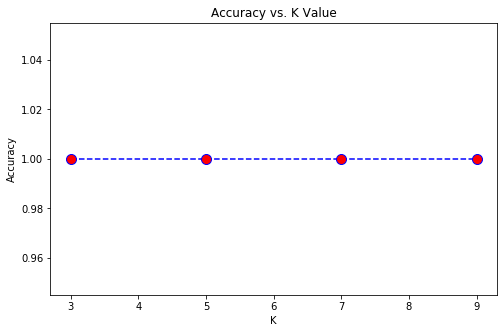

In [16]:
#A graph of K values and their corresponding accuracy performance
plt.figure(figsize=(8,5))
plt.plot(K,accuracy,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [17]:
#Save a model and load the same to get the testing accuracy with the optimal model
pickle.dump(bestModel, open('../1095709_KNN.pkl','wb'))
loadmodel_knn = pickle.load(open('../1095709_KNN.pkl','rb'))
loaded_knn_pred = loadmodel_knn.predict(test_features)
showClassficationResults(y_test,loaded_knn_pred)

Detailed Classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       148
         1.0       1.00      1.00      1.00       141
         2.0       1.00      1.00      1.00       161

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



Confusion matrix: 
 [[148   0   0]
 [  0 141   0]
 [  0   0 161]]


In [18]:
#Optimal parameters used for KNN
loadmodel_knn.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')>

#### Random forest on extracted features

In [19]:
rfc = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV

#############Hyperparameters to be tuned using random search###############

# Number of trees in random forest
n_estimators = [int(x) for x in range(20,100,10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [20]:
#Save the model and load it to test images. Show the confusion matrix for the optimal performance.
pickle.dump(rf_random, open('../1095709_RF.pkl','wb'))
loadmodel_rfc = pickle.load(open('../1095709_RF.pkl','rb'))
loaded_rfc_pred = loadmodel_rfc.predict(test_features)
showClassficationResults(y_test,loaded_rfc_pred)

Detailed Classification report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       148
         1.0       1.00      1.00      1.00       141
         2.0       1.00      1.00      1.00       161

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



Confusion matrix: 
 [[148   0   0]
 [  0 141   0]
 [  0   0 161]]


In [21]:
#Best hyperparameters used for RF prediction
rf_random.best_params_

{'n_estimators': 80, 'max_features': 'sqrt', 'max_depth': 20}